In [ ]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter, ListedColormap
# %matplotlib inline

class Network:
    def __init__(self, sizes):
        """
        Initialize the neural network

        :param sizes: a list of the number of neurons in each layer
        """
        # save the number of layers in the network
        self.L = len(sizes)

        # store the list of layer sizes
        self.sizes = sizes

        # initialize the bias vectors for each hidden and output layer
        self.b = [np.random.randn(n, 1) for n in self.sizes[1:]]

        # initialize the matrices of weights for each hidden and output layer
        self.W = [np.random.randn(n, m) for (m, n) in zip(self.sizes[:-1], self.sizes[1:])]

        # initialize the derivatives of biases for backprop
        self.db = [np.zeros((n, 1)) for n in self.sizes[1:]]

        # initialize the derivatives of weights for backprop
        self.dW = [np.zeros((n, m)) for (m,n) in zip(self.sizes[:-1], self.sizes[1:])]

        # initialize the activities on each hidden and output layer
        self.z = [np.zeros((n, 1)) for n in self.sizes]

        # initialize the activations on each hidden and output layer
        self.a = [np.zeros((n, 1)) for n in self.sizes]

        # initialize the deltas on each hidden and output layer
        self.delta = [np.zeros((n, 1)) for n in self.sizes]

    def g(self, z):
        """
        sigmoid activation function

        :param z: vector of activities to apply activation to
        """
        return 1.0 / (1.0 + np.exp(-z))

    def g_prime(self, z):
        """
        derivative of sigmoid activation function

        :param z: vector of activities to apply derivative of activation to
        """
        return self.g(z) * (1.0 - self.g(z))

    def grad_loss(self, a, y):
        """
        evaluate gradient of cost function for squared-loss C(a,y) = (a-y)^2/2

        :param a: activations on output layer
        :param y: vector-encoded label
        """
        return (a - y)

    def forward_prop(self, x):
        """
        take an feature vector and propagate through network

        :param x: input feature vector
        """
        if len(x.shape) == 1:
            x = x.reshape(-1, 1)
        # TODO: step 1. Initialize activation on initial layer to x
        # your code here

        self.a[0]=x
        self.z[0]=x

        ## TODO: step 2-4. Loop over layers and compute activities and activations
        # your code here

        for i in range(self.L-1):
            self.z[i+1]=np.add(self.W[i].dot(self.a[i]), self.b[i])
            self.a[i+1]=self.g(self.z[i+1])


    def back_prop(self, x, y):
        """
        Back propagation to get derivatives of C wrt weights and biases for given training example

        :param x: training features
        :param y: vector-encoded label
        """

        if len(y.shape) == 1:
            y = y.reshape(-1, 1)

        # TODO: step 1. forward prop training example to fill in activities and activations
        # your code here

        self.forward_prop(x)

        # TODO: step 2. compute deltas on output layer (Hint: python index numbering starts from 0 ends at N-1)
        # your code here

        self.delta[self.L-1]=self.grad_loss(self.a[self.L-1], y)*self.g_prime(self.z[self.L-1])

        # TODO: step 3-6. loop backward through layers, backprop deltas, compute dWs and dbs
        # your code here

        for i in range(self.L-2, -1, -1):
            self.db[i]=self.delta[i+1]
            self.delta[i]=self.W[i].T.dot(self.delta[i+1])*self.g_prime(self.z[i])
            self.dW[i]=self.delta[i+1].dot(self.a[i].T)

    def train(self, X_train, y_train, X_valid=None, y_valid=None,
              eta=0.25, num_epochs=10, isPrint=True, isVis=False):
        """
        Train the network with SGD

        :param X_train: matrix of training features
        :param y_train: matrix of vector-encoded labels
        """

        # initialize shuffled indices
        shuffled_inds = list(range(X_train.shape[0]))

        # loop over training epochs (step 1.)
        for ep in range(num_epochs):

            # shuffle indices
            np.random.shuffle(shuffled_inds)

            # loop over training examples (step 2.)
            for ind in shuffled_inds:

                # TODO: step 3. back prop to get derivatives
                # your code here

                self.back_prop(X_train[ind,:], y_train[ind,:])

                # TODO: step 4. update weights and biases
                # your code here

                for i in range(self.L-1):
                    self.W[i]=self.W[i]-eta*self.dW[i]
                    self.b[i]=self.b[i]-eta*self.db[i]

            # print mean loss every 10 epochs if requested
            if isPrint and (ep % 10) == 0:
                print("epoch {:3d}/{:3d}: ".format(ep, num_epochs), end="")
                print("  train loss: {:8.3f}".format(self.compute_loss(X_train, y_train)), end="")
                if X_valid is not None:
                    print("  validation loss: {:8.3f}".format(self.compute_loss(X_valid, y_valid)))
                else:
                    print("")

            if isVis and (ep % 20) == 0:
                self.pretty_pictures(X_train, y_train, decision_boundary=True, epoch=ep)

    def compute_loss(self, X, y):
        """
        compute average loss for given data set

        :param X: matrix of features
        :param y: matrix of vector-encoded labels
        """
        loss = 0
        if len(X.shape) == 1:
            X = X[np.newaxis, :]
        if len(y.shape) == 1:
            y = y[np.newaxis, :]
        for x, t in zip(X, y):
            self.forward_prop(x)
            if len(t.shape) == 1:
                t = t.reshape(-1, 1)
            loss += 0.5 * np.sum((self.a[-1] - t) ** 2)
        return loss / X.shape[0]


    def gradient_check(self, x, y, h=1e-5):
        """
        check whether the gradient is correct for X, y

        Assuming that back_prop has finished.
        """
        for ll in range(self.L - 1):
            oldW = self.W[ll].copy()
            oldb = self.b[ll].copy()
            for i in range(self.W[ll].shape[0]):
                for j in range(self.W[ll].shape[1]):
                    self.W[ll][i, j] = oldW[i, j] + h
                    lxph = self.compute_loss(x, y)
                    self.W[ll][i, j] = oldW[i, j] - h
                    lxmh = self.compute_loss(x, y)
                    grad = (lxph - lxmh) / (2 * h)
                    assert abs(self.dW[ll][i, j] - grad) < 1e-5
                    self.W[ll][i, j] = oldW[i, j]
            for i in range(self.b[ll].shape[0]):
                j = 0
                self.b[ll][i, j] = oldb[i, j] + h
                lxph = self.compute_loss(x, y)
                self.b[ll][i, j] = oldb[i, j] - h
                lxmh = self.compute_loss(x, y)
                grad = (lxph - lxmh) / (2 * h)
                assert abs(self.db[ll][i, j] - grad) < 1e-5
                self.b[ll][i, j] = oldb[i, j]



###################
#Code below this line are provided by coursera, an online course that I am
#taking
###################

    def pretty_pictures(self, X, y, decision_boundary=False, epoch=None):
        """
        Function to plot data and neural net decision boundary

        :param X: matrix of features
        :param y: matrix of vector-encoded labels
        :param decision_boundary: whether or not to plot decision
        :param epoch: epoch number for printing
        """

        mycolors = {"blue": "steelblue", "red": "#a76c6e"}
        colorlist = [c for (n,c) in mycolors.items()]
        colors = [colorlist[np.argmax(yk)] for yk in y]

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))

        if decision_boundary:
            xx, yy = np.meshgrid(np.linspace(-1.25,1.25,300), np.linspace(-1.25,1.25,300))
            grid = np.column_stack((xx.ravel(), yy.ravel()))
            grid_pred = np.zeros_like(grid[:,0])
            for ii in range(len(grid_pred)):
                self.forward_prop(grid[ii,:])
                grid_pred[ii] = np.argmax(self.a[-1])
            grid_pred = grid_pred.reshape(xx.shape)
            cmap = ListedColormap([
                colorConverter.to_rgba('steelblue', alpha=0.30),
                colorConverter.to_rgba('#a76c63', alpha=0.30)])
            plt.contourf(xx, yy, grid_pred, cmap=cmap)
            if epoch is not None: plt.text(-1.23,1.15, "epoch = {:d}".format(epoch), fontsize=16)

        plt.scatter(X[:,0], X[:,1], color=colors, s=100, alpha=0.9)
        plt.axis('off')

def generate_data(N, config="checkerboard"):
    X = np.zeros((N,2))
    y = np.zeros((N,2)).astype(int)

    if config=="checkerboard":
        nps, sqlen = N//9, 2/3
        ctr = 0
        for ii in range(3):
            for jj in range(3):
                X[ctr * nps : (ctr + 1) * nps, :] = np.column_stack(
                    (np.random.uniform(ii * sqlen +.05-1, (ii+1) * sqlen - .05 -1, size=nps),
                     np.random.uniform(jj * sqlen +.05-1, (jj+1) * sqlen - .05 -1, size=nps)))
                y[ctr*nps:(ctr+1)*nps,(3*ii+jj)%2] = 1
                ctr += 1

    if config=="blobs":
        X, yflat = datasets.make_blobs(n_samples=N, centers=[[-.5,.5],[.5,-.5]],
                                       cluster_std=[.20,.20],n_features=2)
        for kk, yk in enumerate(yflat):
            y[kk,:] = np.array([1,0]) if yk else np.array([0,1])


    if config=="circles":
        kk=0
        while kk < N / 2:
            sample = 2 * np.random.rand(2) - 1
            if np.linalg.norm(sample) <= .45:
                X[kk,:] = sample
                y[kk,:] = np.array([1,0])
                kk += 1
        while kk < N:
            sample = 2 * np.random.rand(2) - 1
            dist = np.linalg.norm(sample)
            if dist < 0.9 and dist > 0.55:
                X[kk,:] = sample
                y[kk,:] = np.array([0,1])
                kk += 1

    if config=="moons":
        X, yflat = datasets.make_moons(n_samples=N, noise=.05)
        X[:,0] = .5 * (X[:,0] - .5)
        X[:,1] = X[:,1] - .25
        for kk, yk in enumerate(yflat):
            y[kk, :] = np.array([1,0]) if yk else np.array([0,1])

    return X, y

from IPython.core.display import HTML
HTML("""
<style>
.MathJax nobr>span.math>span{border-left-width:0 !important};
</style>
""")

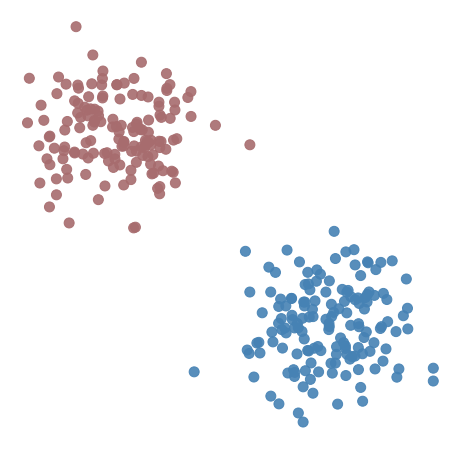

In [ ]:
nn = Network([2,3,2])
X_train, y_train = generate_data(300, "blobs")
nn.pretty_pictures(X_train, y_train, decision_boundary=False)